In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
from sklearn.datasets import make_blobs
import math

In [2]:
def create_random_uniform_datapoints(N):
    x = np.random.rand(N)
    y = np.random.rand(N)
    colors = ['r' if x else 'b' for x in np.random.randint(2, size=N)]
    coords = [(a,b) for a,b in zip(x.tolist(), y.tolist())]
    data = [(coords[i][0], coords[i][1], colors[i]) for i in range(N)]
    return x, y, data, colors

In [3]:
def create_blob_datapoints(N, std=1, k=2):
    coords, labels = make_blobs(n_samples=N, centers=k, cluster_std=std, n_features=2)
    x = [it[0] for it in coords.tolist()]
    y = [it[1] for it in coords.tolist()]
    colors = ['r' if c_ind==0 else 'b' for c_ind in labels]
    data = [(coords[i][0], coords[i][1], colors[i]) for i in range(N)]
    return x, y, data, colors

In [4]:
def compute_entropy(p1, p2):
    if p1==p2==0:
        return 0 
    elif p1==0:
        return - p2 * math.log(p2)
    elif p2==0:
        return - p1 * math.log(p1)
    else:
        return - p1 * math.log(p1) - p2 * math.log(p2)

In [5]:
def find_weighted_weak_learner(points, sample_weights=None):
    """
    Args: 
    Takes the data and the sample weights and outputs a weak learner. This weak learner looks at all
    horizontal and vertical lines and picks a line that maximizes the information gain when splitting
    the decision tree. Sample weight is used in deciding the splits, look at:
    https://datascience.stackexchange.com/questions/56250/how-does-class-weight-work-in-decision-tree?newreg=f018d01fd6d34ef8a0520158ea661484
    
    Returns:
    A tuple containing the axis, dividing point and the color to the left or above. 
    
    Blue color = 1 and Red color = -1 
    """
    N = len(points)
    if not sample_weights:
        sample_weights = [1/N for _ in range(N)]
    points = [(points[i][0], points[i][1], points[i][2], sample_weights[i]) for i in range(N)]
    
    blue = Counter([x[2] for x in points])['b'] 
    red = N - blue  
    
    current_entropy = compute_entropy(blue/N, red/N) 
    
    data_x_sorted = deepcopy(points)
    data_x_sorted.sort(key= lambda x:x[0])

    data_y_sorted = deepcopy(points)
    data_y_sorted.sort(key= lambda x:x[1])
    
    xy_candidates = [] 
    for direction in [data_x_sorted, data_y_sorted]:
        l_blue, l_red, r_blue, r_red, l_count, r_count, l_weight, r_weight = 0, 0, blue, red, 0, N, 0, 1
        min_entropy = current_entropy 
        min_index = -1 
        right_or_above_color = 'b'   # label 1
        for i in range(N-1):
            if direction[i][2]=='b':  # label 1 
                l_blue  += 1
                r_blue  -= 1 
            else:
                l_red += 1
                r_red -= 1 

            l_count += 1
            r_count -= 1
            
            l_weight += direction[i][3]
            r_weight -= direction[i][3]
            
            left_entropy = compute_entropy(l_blue/l_count, l_red/l_count)
            right_entropy = compute_entropy(r_blue/r_count, r_red/r_count)
            
            split_entropy = l_weight * left_entropy + r_weight * right_entropy 
        
            if split_entropy <= min_entropy:
                min_entropy = split_entropy
                min_index = i 
                if r_red > r_blue:
                    right_or_above_color = 'r'  # or -1 label
                else:
                    right_or_above_color = 'b'  # or 1 label 
                
        xy_candidates.append((min_index, min_entropy, right_or_above_color))
        
    if xy_candidates[0][1] <= xy_candidates[1][1]:
        return 'x', 0.5*(data_x_sorted[xy_candidates[0][0]][0] + data_x_sorted[xy_candidates[0][0] + 1][0]), xy_candidates[0][2]
    else:
        return 'y', 0.5*(data_y_sorted[xy_candidates[1][0]][1] + data_y_sorted[xy_candidates[1][0] + 1][1]), xy_candidates[1][2]

In [6]:
def predict_and_compute_error(points, axis, num, color):
    error = 0 
    predictions = []
    for x_coord, y_coord, target_color in points:
        if axis == 'x':
            if x_coord > num:
                prediction_color = color
            else:
                prediction_color = (set(['b','r']) - set(color)).pop()
        elif axis == 'y':
            if y_coord > num:
                prediction_color = color
            else:
                prediction_color = (set(['b','r']) - set(color)).pop()
        
        if prediction_color != target_color:
            error += 1 
        predictions.append(prediction_color)
    return error/len(points), predictions

In [7]:
def find_adaboost_learners(points, T):
    """
    Finds the strong PAC learner through Ada-Boost learner. Takes the data points and use them to find weak 
    learners in each iteration of the boosting algorithm. T is the total number of boosting iterations. 
    
    Return the complex boosting learner. 
    
    Blue color = 1 and Red color = -1
    """
    N = len(points)
    D_vec_t = [1/N for _ in range(N)]
    weak_learner_set = []

    for _ in range(T): 
        axis, num, color = find_weighted_weak_learner(points, D_vec_t)
        epsilon_t, predicted_colors = predict_and_compute_error(points, axis, num, color)
        
        #for h in range(N):
        #    print('%.2f' % points[h][0], '\t %.2f' % points[h][1], "\t Actual :", points[h][2],\
        #          "\t Predicted :", predicted_colors[h], "\t weight:", '%.4f' % D_vec_t[h])
        #print("----------------------------")
        if epsilon_t==0:
            weak_learner_set.append((axis, num, color, float("inf")))
            print("Perfect algorithm!")
            break 
        alpha_t = 0.5 * math.log((1-epsilon_t)/epsilon_t)
        weak_learner_set.append((axis, num, color, alpha_t))
        unnormalized_new_D_vec_t = [D_vec_t[i] * math.exp(-alpha_t) if predicted_colors[i] == points[i][2] else\
                                    D_vec_t[i] * math.exp(alpha_t) for i in range(N)]
        Z_t = sum(unnormalized_new_D_vec_t)
        D_vec_t = [ui/Z_t for ui in unnormalized_new_D_vec_t]
        
    return weak_learner_set

In [39]:
def predict_adaboost_error(points, weak_learners):
    error = 0 
    predictions = []
    for x_coord, y_coord, target_color in points:
        all_learners_contributions = 0
        for learner in weak_learners:
            axis, num, color, weight = learner
            if axis == 'x':
                if x_coord > num:
                    learner_prediction_color = color
                else:
                    learner_prediction_color = (set(['b','r']) - set(color)).pop()
            elif axis == 'y':
                if y_coord > num:
                    learner_prediction_color = color
                else:
                    learner_prediction_color = (set(['b','r']) - set(color)).pop()

            # Remember that blue color is represented by 1 and red is represented by -1 
            learner_contribution = weight if learner_prediction_color == 'b' else -weight
            all_learners_contributions += learner_contribution
        
        if all_learners_contributions >= 0:
            prediction_color = 'b'
        else:
            prediction_color = 'r'
        
        if prediction_color != target_color:
            error += 1
        predictions.append(prediction_color)
    return error/len(points), predictions

In [9]:
def plot_line(axis, num):
    if axis == 'x':
        plt.axvline(x=num)
    elif axis == 'y':
        plt.axhline(y=num)

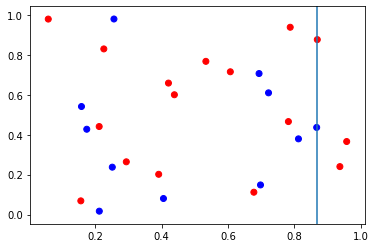

Right or above color: r 	 error: 0.481481


In [41]:
x, y, data1, colors = create_random_uniform_datapoints(27)
#x, y, data1, colors = create_blob_datapoints(50, std=2)
plt.scatter(x, y, c = colors)
axis, num, color = find_weighted_weak_learner(data1)
plot_line(axis, num)
plt.show()
err, _ = predict_and_compute_error(data1, axis, num, color)
print("Right or above color:",color, "\t error: {:2f}".format(err))

Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: y  Threshold: 0.710421  Right or above color: r  Weight: 0.187347
Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.868006  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.157785  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.157785  Right or above color: r  Weight: 0.037054
Axis: x  Threshold: 0.157785  Right or above color: r  Weight: 0.037054


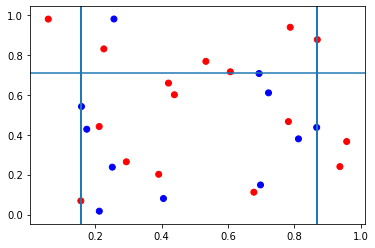

In [52]:
learners = find_adaboost_learners(data1, 10)
plt.scatter(x, y, c = colors)
for axis, num, color, weight in learners:
    print("Axis:", axis, " Threshold: {:2f}".format(num), " Right or above color:", \
          color, " Weight: {:2f}".format(weight))
    plot_line(axis, num)

In [53]:
err, _ = predict_adaboost_error(data1, learners)
print("Boosting algorithm prediction error: {:2f}".format(err))

Boosting algorithm prediction error: 0.370370
